In [149]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

## [1] MNIST 데이터 준비

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.reshape(-1, 28, 28, 1), x_test.reshape(-1, 28, 28, 1)
x_train, x_test = x_train / 255., x_test / 255.
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

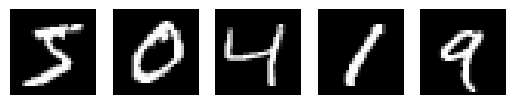

In [3]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()

## [2] 모델 학습

In [4]:
def lenet5(num_classes=10):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(6, 5, activation='relu', input_shape=(28, 28, 1), padding='same'),
        tf.keras.layers.AvgPool2D(2),
        tf.keras.layers.Conv2D(16, 5, activation='relu'),
        tf.keras.layers.AvgPool2D(2),
        tf.keras.layers.Conv2D(120, 5, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84,activation='tanh'),
        tf.keras.layers.Dense(num_classes)
    ])
    
    return model

In [5]:
model = lenet5()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics='accuracy')

2023-05-21 22:13:17.964584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22215 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
history = model.fit(x_train, y_train, epochs=5, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/5


2023-05-21 22:13:19.708939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-21 22:13:20.098366: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-21 22:13:20.139454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-21 22:13:20.140740: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x218a7d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 22:13:20.140753: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-05-21 22:13:20.143641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-21 22:13:20.186161

235/235 [==============================] - 3s 3ms/step - loss: 0.4709 - accuracy: 0.8737 - val_loss: 0.1491 - val_accuracy: 0.9543
Epoch 2/5
235/235 [==============================] - 0s 2ms/step - loss: 0.1203 - accuracy: 0.9634 - val_loss: 0.0836 - val_accuracy: 0.9750
Epoch 3/5
235/235 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9750 - val_loss: 0.0699 - val_accuracy: 0.9774
Epoch 4/5
235/235 [==============================] - 0s 2ms/step - loss: 0.0653 - accuracy: 0.9800 - val_loss: 0.0554 - val_accuracy: 0.9830
Epoch 5/5
235/235 [==============================] - 0s 2ms/step - loss: 0.0543 - accuracy: 0.9834 - val_loss: 0.0443 - val_accuracy: 0.9855


## [3] Strategy 1: Increasing Pixel Intensities

In [150]:
def increase_intensity(img, target_class):
    # img.shape = (1, 28, 28, 1)
    
    search_indices = np.ones((784,))
    X = np.copy(img)
    
    while True:
        inputs = tf.Variable(X)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inputs)
            outputs = model(inputs)
            pred = np.argmax(outputs[0])
            outputs = [ output for output in outputs[0]]
        
        if pred == target_class:
            break
        
        # (1) forward derivative
        grads = np.stack([ tape.gradient(output, inputs)[0, :, :, 0] for output in outputs])
        grads = grads.reshape(-1, 28 * 28)
        
        # (2) saliency map
        saliency_map = np.zeros((28 * 28,))
        mask = np.ones(10)
        mask[target_class] = 0
        
        for i in range(784):
            if search_indices[i] == 0:
                continue

            target_grad = grads[target_class, i]
            untarget_grad = (grads[:, i] * mask).sum()
            if target_grad < 0 or untarget_grad > 0:
                continue
            saliency_map[i] = target_grad * np.abs(untarget_grad)
            
        noise_idx = np.argmax(saliency_map)
        search_indices[noise_idx] = 0
        
        # (3) modify argmax pixel
        noise_i, noise_j = noise_idx // 28, noise_idx % 28
        X[:, noise_i, noise_j, :] = 1.
    
    return X

In [151]:
original_class = 1

sample_indices = np.arange(len(y_test))[y_test == original_class]
sample_idx = np.random.choice(sample_indices)

sample = x_test[sample_idx:sample_idx+1]

output_images = []
for target_class in tqdm(range(10), ncols=80, ascii=True):
    output = increase_intensity(sample, target_class=target_class)
    output_images.append(output)

100%|###########################################| 10/10 [00:04<00:00,  2.21it/s]


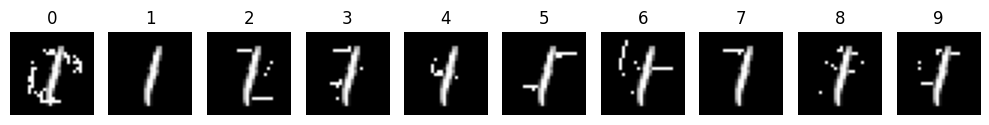

In [152]:
plt.figure(figsize=(10, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(output_images[i][0, :, :, 0], cmap='gray')
    plt.title(i)
    plt.axis('off')
plt.tight_layout()
plt.show()

## [4] Strategy 2: Decreasing Pixel Intensities

In [145]:
def decrease_intensity(img, target_class):
    # img.shape = (1, 28, 28, 1)
    
    search_indices = np.ones((784,))
    X = np.copy(img)
    
    for _ in range(784):  
        inputs = tf.Variable(X)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(inputs)
            outputs = model(inputs)
            pred = np.argmax(outputs[0])
            outputs = [ output for output in outputs[0]]
        
        if pred == target_class:
            break
        
        # (1) forward derivative
        grads = np.stack([ tape.gradient(output, inputs)[0, :, :, 0] for output in outputs])
        grads = grads.reshape(-1, 28 * 28)
        
        # (2) saliency map
        saliency_map = np.zeros((28 * 28,))
        mask = np.ones(10)
        mask[target_class] = 0
        
        for i in range(784):
            if search_indices[i] == 0:
                continue

            target_grad = grads[target_class, i]
            untarget_grad = (grads[:, i] * mask).sum()
            if target_grad > 0 or untarget_grad < 0:
                continue
            saliency_map[i] = np.abs(target_grad) * untarget_grad
            
        noise_idx = np.argmax(saliency_map)
        search_indices[noise_idx] = 0
        
        # (3) modify argmax pixel
        noise_i, noise_j = noise_idx // 28, noise_idx % 28
        X[:, noise_i, noise_j, :] = 0.
    
    return X

In [147]:
original_class = 8

sample_indices = np.arange(len(y_test))[y_test == original_class]
sample_idx = np.random.choice(sample_indices)

sample = x_test[sample_idx:sample_idx+1]

output_images = []
for target_class in tqdm(range(10), ncols=80, ascii=True):
    output = decrease_intensity(sample, target_class=target_class)
    output_images.append(output)

100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.49s/it]


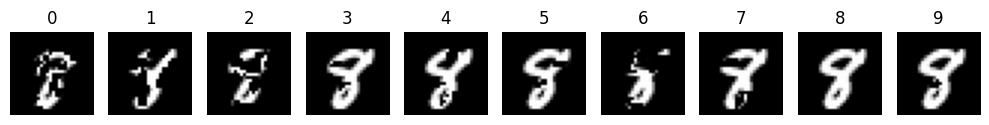

In [148]:
plt.figure(figsize=(10, 2))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(output_images[i][0, :, :, 0], cmap='gray')
    plt.title(i)
    plt.axis('off')
plt.tight_layout()
plt.show()